In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[cuda(id=0)]

In [3]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [4]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 100

# MC parameters
total_steps = 10
total_samples = 200
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [5]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [6]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next
    
    def get_next_idxs_diversity(choose_max, diversity):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        if len(idxs_next) < choose_max:
            idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1

In [7]:
y00.shape

(200, 9)



Starting iteration 1 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:28.209692


Done:  0:00:30.882962
Simulating batch 1: 100 to 200


Done:  0:00:29.988767


Done:  0:00:29.858036




Starting iteration 2 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:31.114269


Done:  0:00:31.348205
Simulating batch 1: 100 to 200


Done:  0:00:28.381992


Done:  0:00:28.762544




Starting iteration 3 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:26.805491


Done:  0:00:28.370047
Simulating batch 1: 100 to 200


Done:  0:00:26.153686


Done:  0:00:29.694861


Starting iteration 4 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:13.435354


Done:  0:00:11.865486
Simulating batch 1: 100 to 200


Done:  0:00:11.992525


Done:  0:00:11.448621


Starting iteration 5 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:13.621605


Done:  0:00:15.595436
Simulating batch 1: 100 to 200


Done:  0:00:14.565696


Done:  0:00:15.587459


Starting iteration 6 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:14.114724


Done:  0:00:14.904049
Simulating batch 1: 100 to 200


Done:  0:00:16.126779


Done:  0:00:16.420900


Starting iteration 7 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:18.946813


Done:  0:00:15.119525
Simulating batch 1: 100 to 200


Done:  0:00:15.268298


Done:  0:00:15.210818


Starting iteration 8 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:15.577562


Done:  0:00:15.105739
Simulating batch 1: 100 to 200


Done:  0:00:16.615015


Done:  0:00:17.176830


Starting iteration 9 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:15.321519


Done:  0:00:15.809319
Simulating batch 1: 100 to 200


Done:  0:00:14.798388


Done:  0:00:15.334249


Starting iteration 10 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:16.411363


Done:  0:00:17.975022
Simulating batch 1: 100 to 200


Done:  0:00:18.804232


Done:  0:00:17.765670


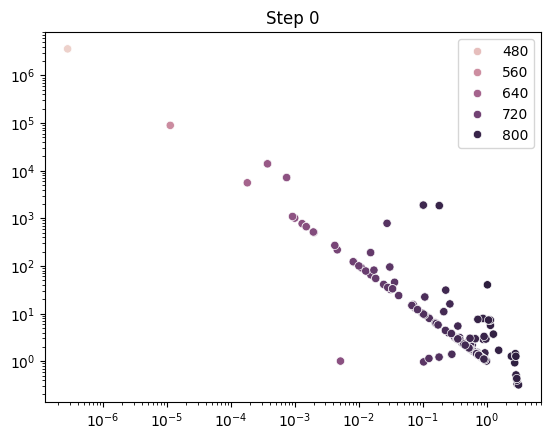

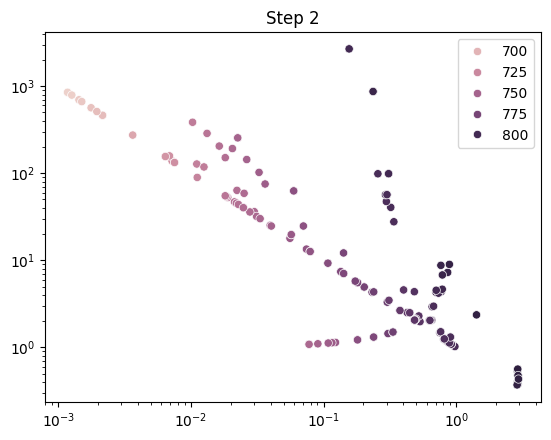

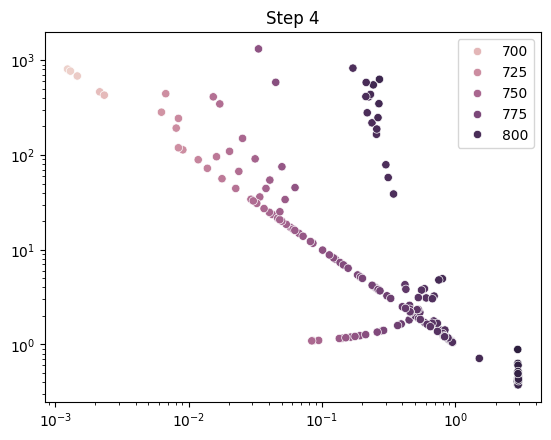

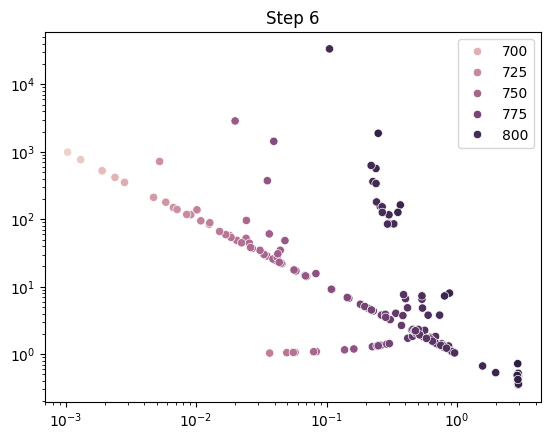

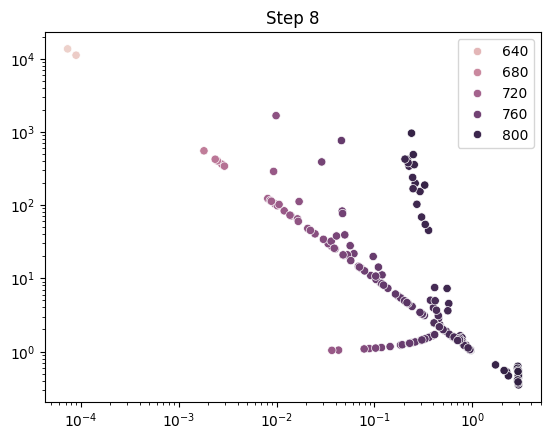

In [8]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies
for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    curr_eq = jax.vmap(
        partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
    _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

    ys0, ts0, ys1, ts1 = simulate(
        y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
    next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                  use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, diversity=diversity)
    
    if np.mod(step, 2) == 0:
        plt.figure()
        sns.scatterplot(x=sensitivity[next_idxs].flatten(), y=precision[next_idxs].flatten(), hue=adaptability[next_idxs].flatten())
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Step {step}')

    # Save results
    all_params_en[step] = curr_en
    all_params_eq[step] = curr_eq
    all_params_rt[step] = curr_rt
    all_is_parent[step][next_idxs] = True
    all_adaptability[step] = adaptability
    all_sensitivity[step] = sensitivity
    all_precision[step] = precision

    # Mutate energies
    next_en = mutate_expand(
        curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
    curr_en = next_en

Maxima - Adaptability: 836.3497314453125, Sensitivity: 9.61009407043457, Precision: inf
Maxima - Adaptability: 834.2667236328125, Sensitivity: 3.2476806640625, Precision: inf


Maxima - Adaptability: 840.7515869140625, Sensitivity: 2.959672451019287, Precision: 4348378.0
Maxima - Adaptability: 819.7382202148438, Sensitivity: 2.967926263809204, Precision: 54793.875
Maxima - Adaptability: 824.9616088867188, Sensitivity: 2.971374034881592, Precision: 55513.57421875


Maxima - Adaptability: 834.7455444335938, Sensitivity: 3.013244390487671, Precision: 2016491.875
Maxima - Adaptability: 836.157958984375, Sensitivity: 2.9886324405670166, Precision: 33624.8671875
Maxima - Adaptability: 820.8749389648438, Sensitivity: 2.9723923206329346, Precision: 382771.6875
Maxima - Adaptability: 821.9151611328125, Sensitivity: 3.011673927307129, Precision: 13617.1982421875
Maxima - Adaptability: 816.7943115234375, Sensitivity: 2.9743118286132812, Precision: 278840.03125


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

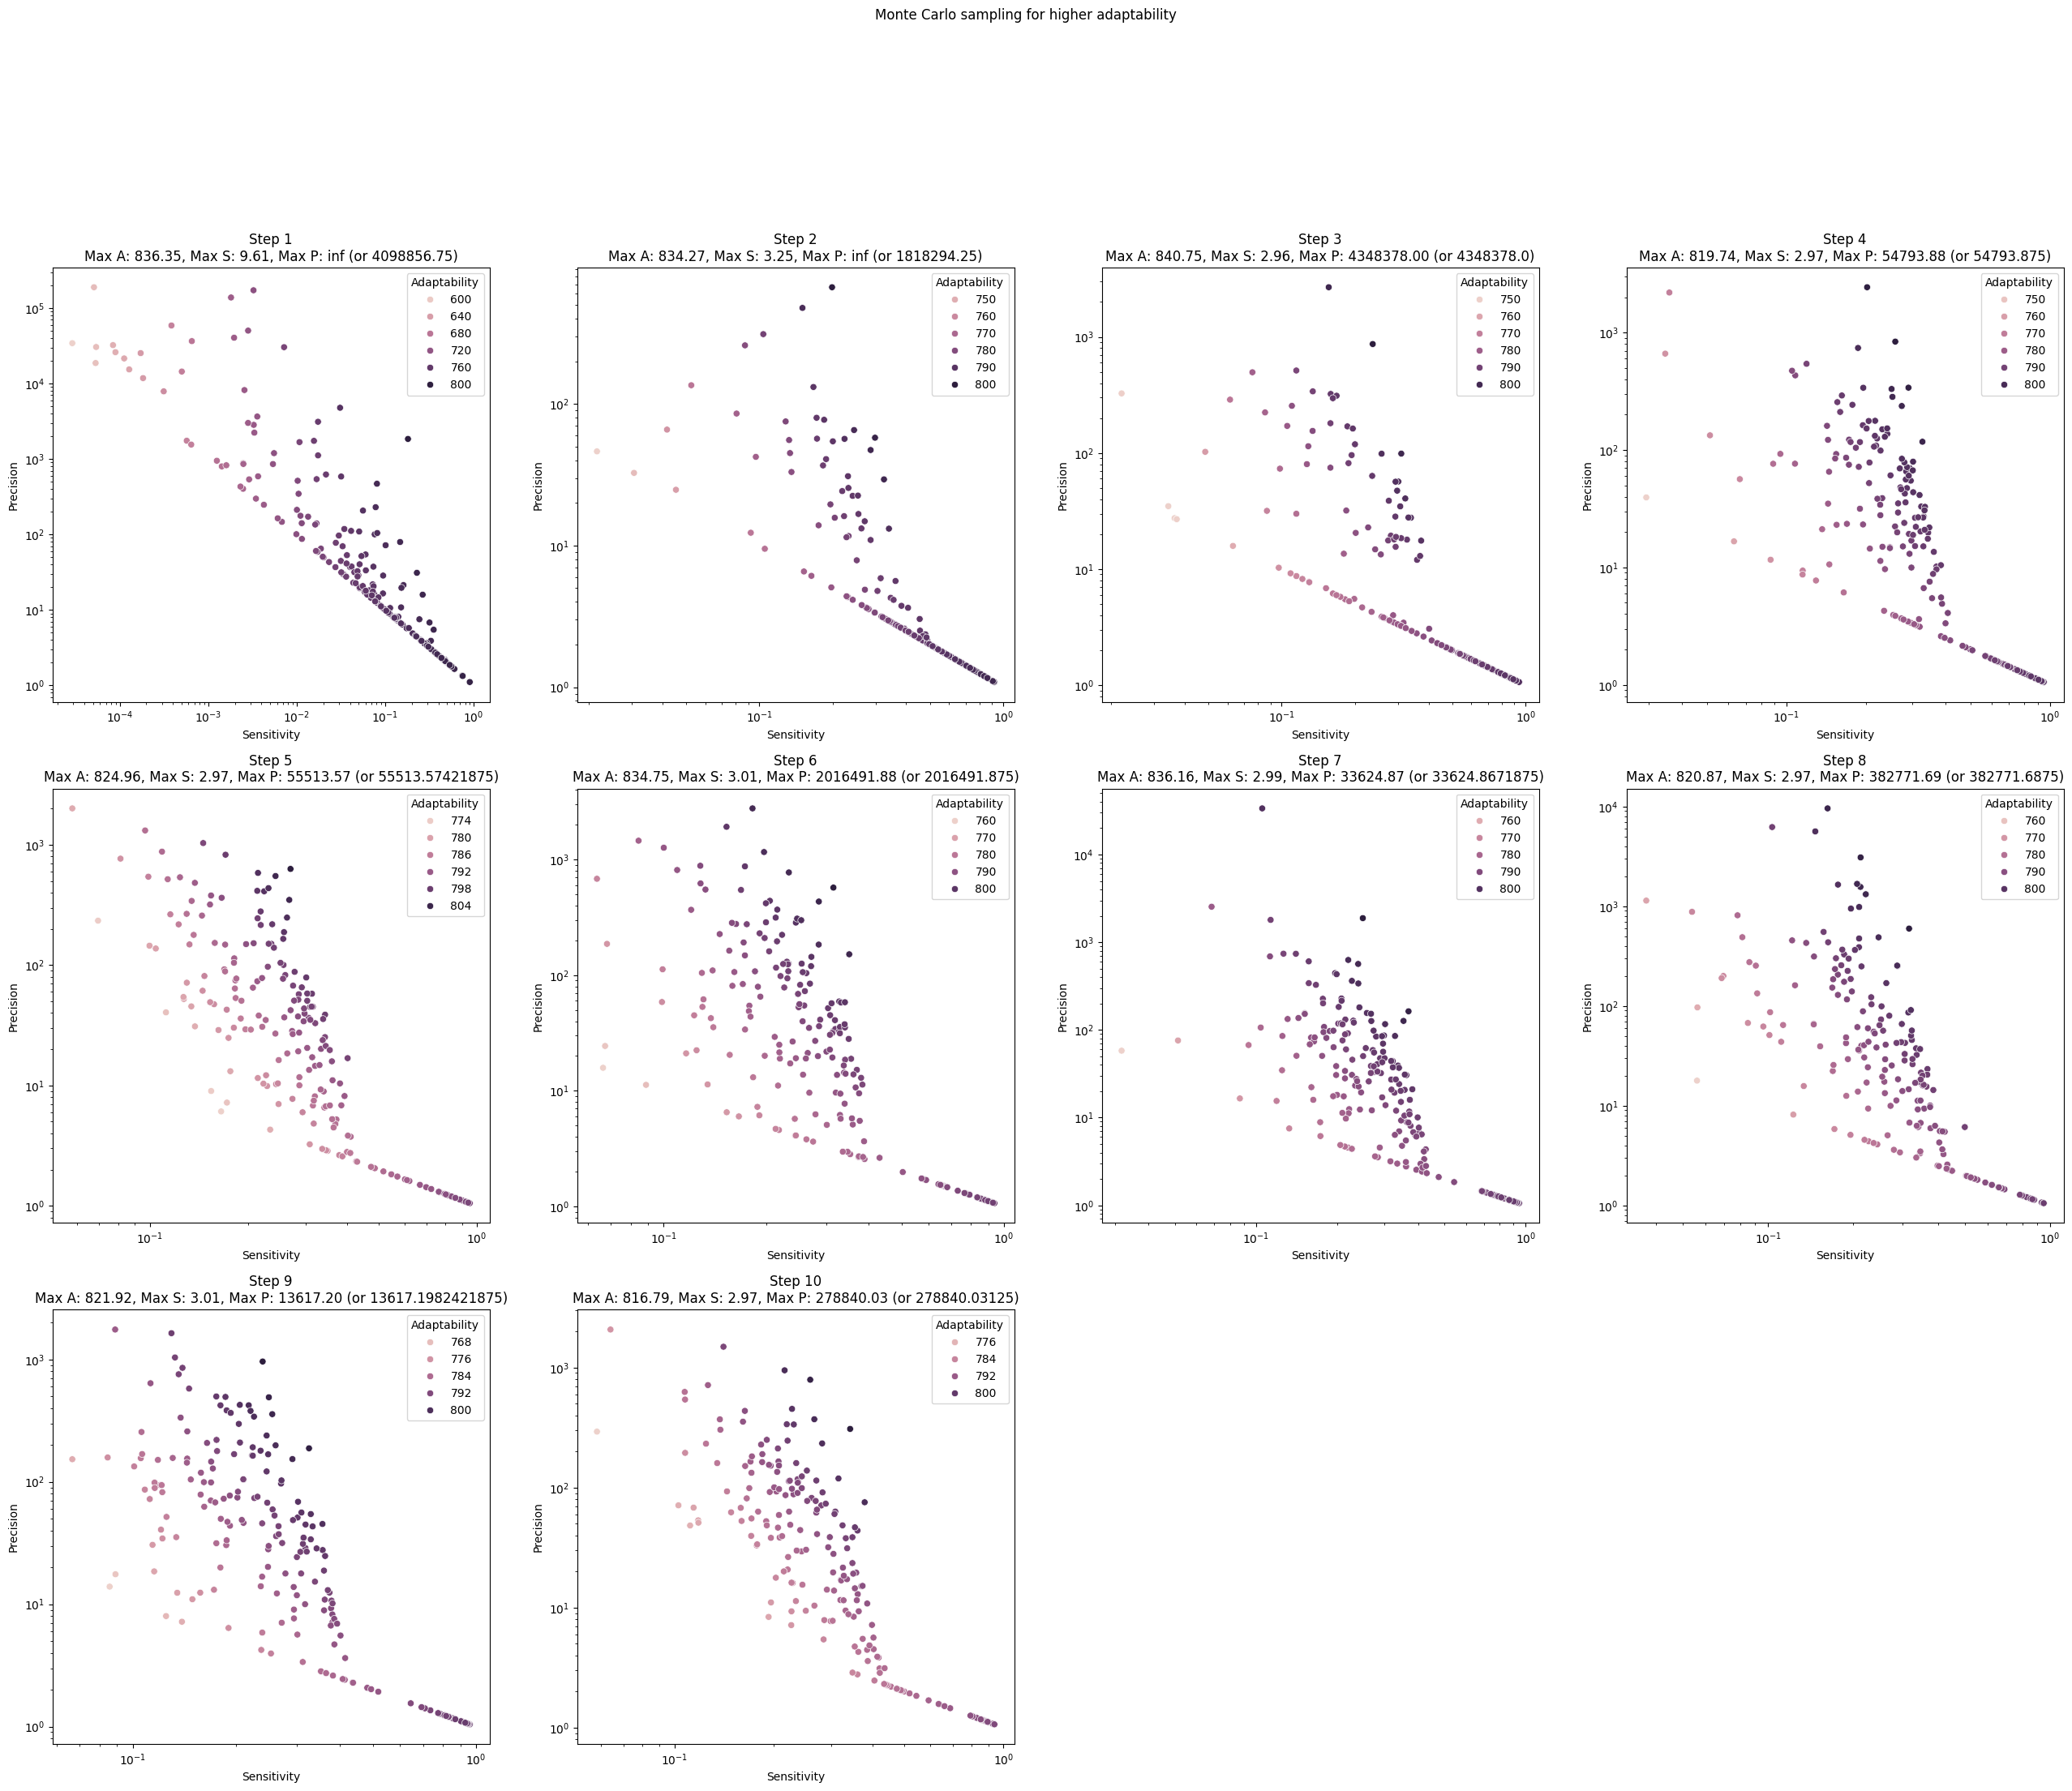

In [9]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                       'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                       'Precision': all_precision[..., idxs_output].flatten(), 
                       'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                       'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                       'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                       'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output))})
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {jnp.nanmax(a)}, Sensitivity: {jnp.nanmax(s)}, Precision: {jnp.nanmax(p)}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {jnp.nanmax(a):.2f}, Max S: {jnp.nanmax(s):.2f}, Max P: {jnp.nanmax(p):.2f} (or {jnp.nanmax(p[p < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: 840.7515869140625, Sensitivity: 2.959672451019287, Precision: 4348378.0
Maxima - Adaptability: 819.7382202148438, Sensitivity: 2.967926263809204, Precision: 54793.875
Maxima - Adaptability: 824.9616088867188, Sensitivity: 2.971374034881592, Precision: 55513.57421875


Maxima - Adaptability: 834.7455444335938, Sensitivity: 3.013244390487671, Precision: 2016491.875
Maxima - Adaptability: 836.157958984375, Sensitivity: 2.9886324405670166, Precision: 33624.8671875
Maxima - Adaptability: 820.8749389648438, Sensitivity: 2.9723923206329346, Precision: 382771.6875
Maxima - Adaptability: 821.9151611328125, Sensitivity: 3.011673927307129, Precision: 13617.1982421875
Maxima - Adaptability: 816.7943115234375, Sensitivity: 2.9743118286132812, Precision: 278840.03125


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

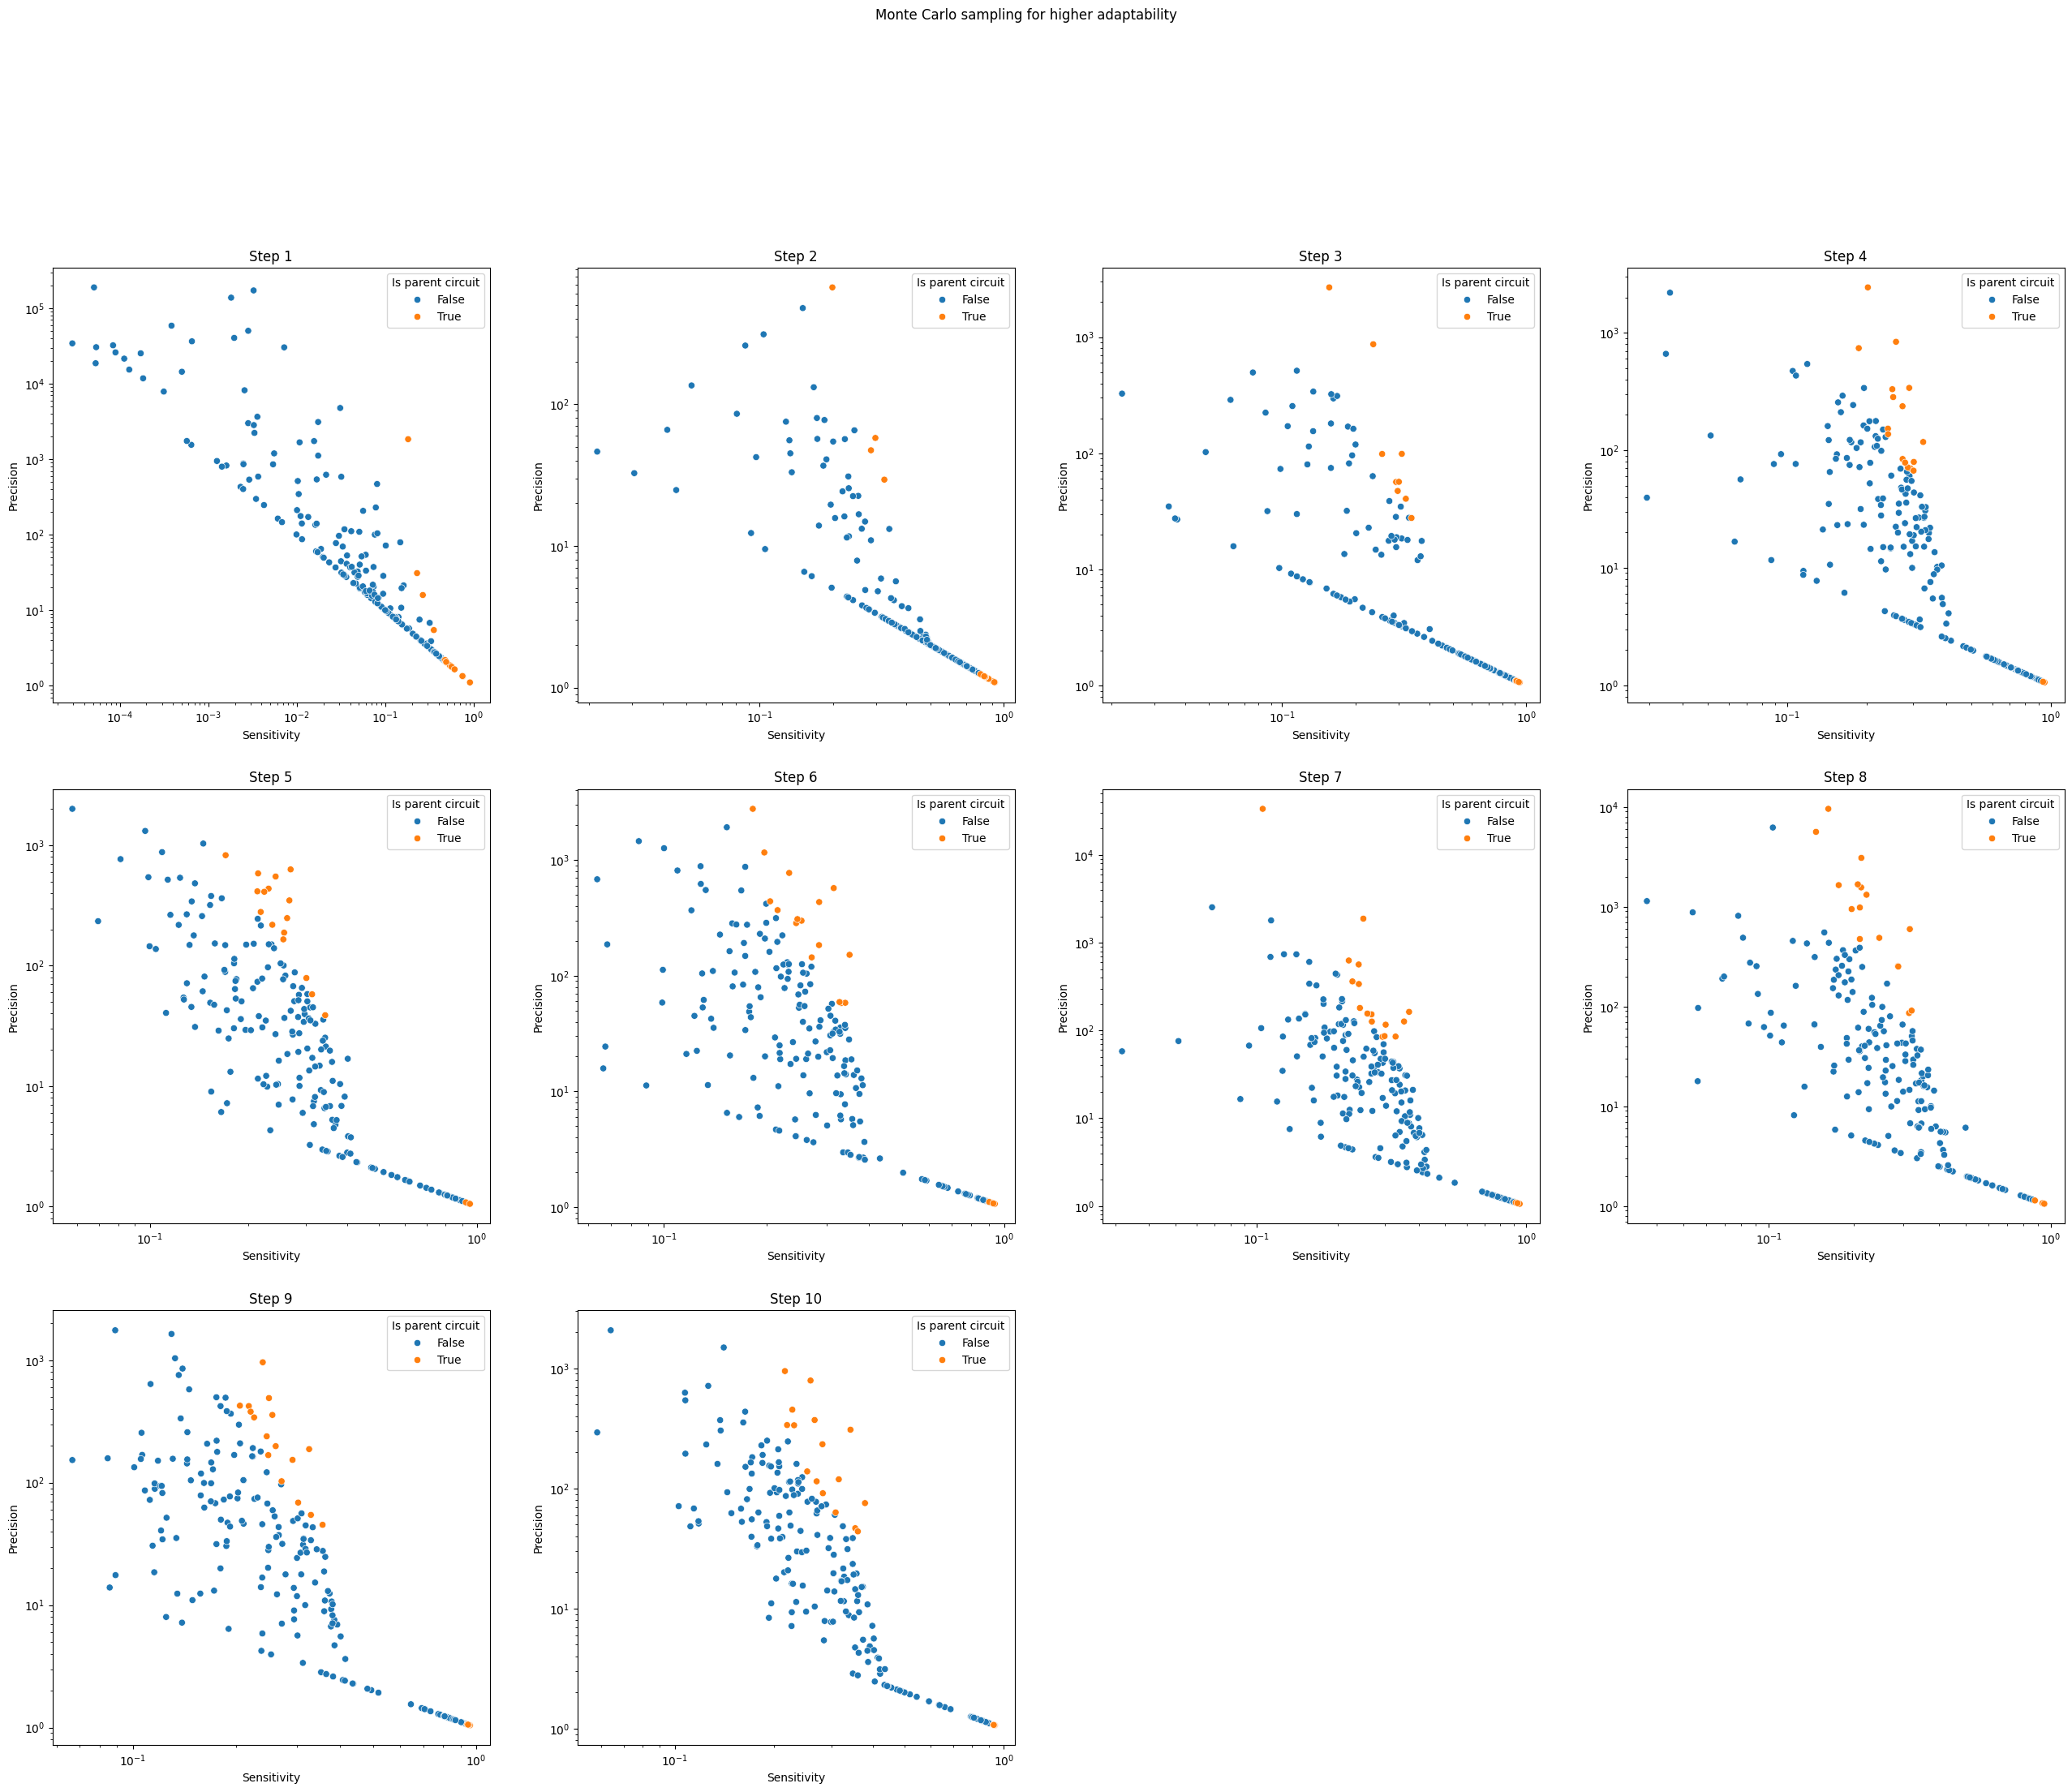

In [10]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')